## Set up

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import pickle
import time
import sys
from collections import Counter


In [2]:
# ==================== Define functions ====================

def Extract_Features(PD, Type = 'Full_Cov'): # Functions that only extract interesting features, remove unrelated columns in the pandas dataframe
    # Input PD is the entire pandas dataframe read from csv (result from Rds files of R)
    # Type is an approach that you want to run
    #   - Full_Cov: Keep all features --> remove x-y coordinates and FOI column
    #   - Only_Bio: Only keep Bioclimatic Features --> remove x-y coordinates, FOI column, and other not-bioclimatic columns
    # Output is an pandas dataframe containing only interesting features columns
    # Note: You need to check the names of columns that you want to remove
    
    if (Type == 'Full_Cov'):
        # Full Covariates --> Using all covariates --> remove x-y coordinates and FOI values columns (keep all features)
        if ('FOI' in PD.columns): # This check is for Endemic dataframe since it does not have FOI column    
            Interest_Features = PD.drop(['x', 'y', 'FOI'], axis = 1)
        else:
            Interest_Features = PD.drop(['x', 'y'], axis = 1)
    else:
        # Only Bio Covariates --> Only using bioclimatic --> remove x-y coordinates, FOI columns, and other columns that are not bioclimatic
        if ('FOI' in PD.columns): 
            Interest_Features = PD.drop(['x', 'y', 'DG_000_014bt_dens', 'Elv', 'Pigs', 'Pop_Count_WP_SEDAC_2015', 'Rice', 'UR', 'VD', 'FOI'], axis = 1)
        else:
            Interest_Features = PD.drop(['x', 'y', 'DG_000_014bt_dens', 'Elv', 'Pigs', 'Pop_Count_WP_SEDAC_2015', 'Rice', 'UR', 'VD'], axis = 1)
    return Interest_Features

np.random.seed(5) # set seed to regenerate the same random result





In [3]:
# ==================== Set up parameters and Read data ====================

Typemodel = 'Full_Cov' # if Full Cov model --> More detail in above Extract_Features functions
#Typemodel = 'Only_Bio' # if only bio model 

Train_Portion = 0.7 # Portion of Train - Validate - Test
Validate_Portion = (1 - Train_Portion) / 2

resolution_grid = 400
Name_Grid_File = 'Grid_' + str(resolution_grid) + '_' + str(resolution_grid) + '.csv'

print('[Type Model] You have chosen ' + Typemodel)

CurDir = os.getcwd() + '/'
Data_All = CurDir + 'Generate/Python_CSV/EM_Imputed_Features_Study.csv' # 'Directory/to/your/EM_Imputed_Features_Study.csv'
Grid = CurDir + 'Generate/Grids_CSV/' + Name_Grid_File # 'Directory/to/your/Grid/' + Name_Grid_File
Data_EndemicDF = CurDir + 'Generate/Python_CSV/Imputed_Features_Endemic.csv' # 'Directory/to/your/Imputed_Features_Endemic.csv'

# Directory to the folder that you want this script exports files to (remember to have slash '/' at the end)
# Default is to create a subfolder named Python_Export and save result to that subfolder   
Savepath = CurDir + 'Generate/Python_Export/' 
if not os.path.exists(Savepath):
    os.makedirs(Savepath)

# Read csv and store in dataframe in pandas
AllData = pd.read_csv(Data_All)
Grid = pd.read_csv(Grid)  
EndemicDF = pd.read_csv(Data_EndemicDF)
EndemicDF = EndemicDF.drop(['FOI'], axis = 1) # remove FOI column (if it has)

# Remove Pop_2015 density (if wanted, since already have Pop_Count people) --> Check feature name again
# AllData = AllData.drop(['Pop_2015'], axis = 1)
# EndemicDF = EndemicDF.drop(['Pop_2015'], axis = 1)

# Check if matching coordinator
if (len(AllData.iloc[:, :2].merge(Grid.iloc[:, :2])) == len(AllData.iloc[:, :2])):
    print('[Checking Calibration] Matched Coordinators')
    # Recreate grid to match with AllData in case of nrow of 2 dataframe is different
    t = pd.merge(AllData.iloc[:, : 2].reset_index(), Grid.iloc[:, : 2].reset_index(), on=['x','y'], suffixes=['_1','_2'])
    Grid = Grid.iloc[t['index_2'], :]
    del t
else:
    sys.exit('[Stop Program] Grid and Data File do not match coordinators --> Check again')





[Type Model] You have chosen Full_Cov
[Checking Calibration] Matched Coordinators


In [4]:
AllData.head()

,x,y,Bio_01,Bio_02,Bio_03,Bio_04,Bio_05,Bio_06,Bio_07,Bio_08,...,Bio_18,Bio_19,DG_000_014bt_dens,Elv,Pigs,Rice,UR,VD,Adjusted_Pop_Count_2015,FOI
0,13717.407892,5959.817018,-3.533434,14.667511,24.080265,1743.920532,25.633081,-35.277302,60.910385,16.902985,...,280.531250,15.885687,0.096940,324.425049,0.086128,8.804602,1,0.285594,27.158179,0.163308
1,13722.407892,5959.817018,-3.515078,14.740572,24.211077,1737.165649,25.591284,-35.291855,60.883141,16.848240,...,281.375214,16.805054,0.106271,339.754822,0.088851,0.000000,1,0.282270,46.891705,0.164386
2,13727.407892,5959.817018,-3.505363,14.655778,24.143412,1735.075928,25.490971,-35.211075,60.702045,16.827511,...,281.311707,16.730371,0.110514,328.791656,0.055739,0.000000,1,0.296362,29.772409,0.165014
3,13747.407892,5959.817018,-3.203640,14.476027,23.880190,1734.776611,25.709829,-34.909279,60.619106,17.131897,...,281.548340,16.541552,2.518467,281.210266,0.125748,5.982415,1,0.187785,10.536764,0.163172
4,13757.407892,5959.817018,-3.142176,15.133987,24.704348,1729.607788,26.100000,-35.160149,61.260151,17.148170,...,282.543854,16.618938,2.763509,273.763184,0.072534,0.000000,1,0.313313,13.470044,0.163207


In [5]:
# ==================== Sampling Grids to define which Grids will be for Train-Validate-Test ====================

# Count freq of pix in each grid
Grid_column = Grid.iloc[:, 2]
Grid_column = np.array(Grid_column)
d = Counter(Grid_column)
grid_freq = np.array(list(d.values())) # number of pix in each grid_numb (belowed)
grid_numb = np.array(list(d.keys()))
del d

# ----- Preprocessing for Sampling train and validate -----
idx_grid_numb_less = np.where(grid_freq < 100)[0] # find idx of grid containing less than 100 pix --> these grids will be automaticly in training set
idx_grid_numb_high = np.where(grid_freq >= 100)[0] # find idx of grid containing more than 100 pix --> these grids will be randomly chosen for training

grid_numb_train_1 = grid_numb[idx_grid_numb_less]
grid_numb_sample = grid_numb[idx_grid_numb_high]

ngrid_train_2 = round(len(grid_numb_sample)*0.7) # 70% train --- 30% test (validate)
ngrid_validate = round(len(grid_numb_sample)*0.15)
ngrid_test = len(grid_numb_sample) - ngrid_train_2 - ngrid_validate
ngrid_train = len(grid_numb_train_1) + ngrid_train_2

print('[Sampling Grid] Training Grids: ' + str(ngrid_train) + ' ----- Validating Grids: ' + str(ngrid_validate) + ' ----- Testing Grids: ' + str(ngrid_test))

print('===== Sampling Model =====')    
grid_numb_sample_shuffle = np.copy(grid_numb_sample)
np.random.shuffle(grid_numb_sample_shuffle)
grid_numb_train_2 = grid_numb_sample_shuffle[:ngrid_train_2]
grid_numb_validate = grid_numb_sample_shuffle[ngrid_train_2:(ngrid_train_2 + ngrid_validate)]
grid_numb_test = grid_numb_sample_shuffle[(ngrid_train_2 + ngrid_validate):]
grid_numb_train = np.append(grid_numb_train_1, grid_numb_train_2)
del grid_numb_sample_shuffle, grid_numb_train_2

# ----- Take index of pixel for each sub-dataset
idx_train = np.where(np.in1d(Grid_column, grid_numb_train))[0]
idx_validate = np.where(np.in1d(Grid_column, grid_numb_validate))[0]
idx_test = np.where(np.in1d(Grid_column, grid_numb_test))[0]

Type = np.zeros(AllData.shape[0])
Type[idx_train] = 1 # index 1 for train
Type[idx_validate] = 2 # index 2 for validate
Type[idx_test] = 3 # index 3 for validate

# Saving Sampling Grid index having 3 columns: x-y coordinates, and Grid index
Coor_Grid_Index = AllData.iloc[:, 0:2]
Coor_Grid_Index = Coor_Grid_Index.assign(Type = pd.Series(Type).values)
filename_grid = 'Grid_Index_' + str(resolution_grid) + '.csv'
print('[Saving] Save Grid Index')
Coor_Grid_Index.to_csv(Savepath + filename_grid, sep='\t', encoding='utf-8')
print('[Saving] Done Saving Grid Index')





[Sampling Grid] Training Grids: 166 ----- Validating Grids: 30 ----- Testing Grids: 30
===== Sampling Model =====
[Saving] Save Grid Index
[Saving] Done Saving Grid Index


In [6]:
# ==================== Create Train-Validate-Test dataset ====================
# ==================== SJ: Thinning the dataset ====================

# ===== Prepare Train =====
Train = AllData.iloc[idx_train, :]
row_na = Train.isnull().any(1) # check whether a row contains NA or not
#idx_row_na = row_na.nonzero()[0] # find index of row containing NA
#SJ: AttributeError: 'Series' object has no attribute 'nonzero'. This method is deprecated. See below
idx_row_na = row_na.to_numpy().nonzero()[0] # find index of row containing NA

print('[Preprocessing] Total Training containing NA: ' + str(len(idx_row_na)) + ' / ' + str(len(Train)) + ' ----- ' + 
      str(round(len(idx_row_na) / len(Train) * 100, 2)) + '%')
Train_Non_NA = Train.drop(Train.index[idx_row_na]) # remove row containing NA

# SJ: Thinning: take 10%
Train_Non_NA = Train_Non_NA.sample(frac = 0.1, replace = False, random_state = 1)

# ----- Extract Features for model -----
X_train = Extract_Features(Train_Non_NA, Typemodel)
Y_train = Train_Non_NA.FOI
Y_train = np.array(Y_train)

# ===== Prepare Validate =====
Validate = AllData.iloc[idx_validate, :]
row_na = Validate.isnull().any(1) # check whether a row contains NA or not
#idx_row_na = row_na.nonzero()[0] # find index of row containing NA
#SJ: AttributeError: 'Series' object has no attribute 'nonzero'. This method is deprecated. See below
idx_row_na = row_na.to_numpy().nonzero()[0] # find index of row containing NA

print('[Preprocessing] Total Validating containing NA: ' + str(len(idx_row_na)) + ' / ' + str(len(Validate)) + ' ----- ' + 
      str(round(len(idx_row_na) / len(Validate) * 100, 2)) + '%')
Validate_Non_NA = Validate.drop(Validate.index[idx_row_na]) # remove row containing NA

# SJ: Thinning: take 10%
Validate_Non_NA = Validate_Non_NA.sample(frac = 0.1, replace = False, random_state = 1)

# ----- Extract Features for model -----
X_validate = Extract_Features(Validate_Non_NA, Typemodel)
Y_validate = Validate_Non_NA.FOI
Y_validate = np.array(Y_validate)

# ===== Prepare Test =====
Test = AllData.iloc[idx_test, :]
row_na = Test.isnull().any(1) # check whether a row contains NA or not
#idx_row_na = row_na.nonzero()[0] # find index of row containing NA
#SJ: AttributeError: 'Series' object has no attribute 'nonzero'. This method is deprecated. See below
idx_row_na = row_na.to_numpy().nonzero()[0] # find index of row containing NA

print('[Preprocessing] Total Testing containing NA: ' + str(len(idx_row_na)) + ' / ' + str(len(Test)) + ' ----- ' + 
      str(round(len(idx_row_na) / len(Test) * 100, 2)) + '%')
Test_Non_NA = Validate.drop(Test.index[idx_row_na]) # remove row containing NA

# SJ: Thinning: take 10%
Test_Non_NA = Test_Non_NA.sample(frac = 0.1, replace = False, random_state = 1)

# ----- Extract Features for model -----
X_test = Extract_Features(Test_Non_NA, Typemodel)
Y_test = Test_Non_NA.FOI
Y_test = np.array(Y_test)

# ===== Prepare EndemicDF =====
row_na = EndemicDF.isnull().any(1) # check whether a row contains NA or not
#idx_row_na = row_na.nonzero()[0] # find index of row containing NA
#SJ: AttributeError: 'Series' object has no attribute 'nonzero'. This method is deprecated. See below
idx_row_na = row_na.to_numpy().nonzero()[0] # find index of row containing NA

print('[Preprocessing] Total EndemicDF containing NA: ' + str(len(idx_row_na)) + ' / ' + str(len(EndemicDF)) + ' ----- ' + 
      str(round(len(idx_row_na) / len(EndemicDF) * 100, 2)) + '%')
EndemicDF_Non_NA = EndemicDF.drop(EndemicDF.index[idx_row_na]) # remove row containing NA
# SJ: Thinning: take 1%
EndemicDF_Non_NA = EndemicDF_Non_NA.sample(frac = 0.01, replace = False, random_state = 1)


# ----- Extract Features for model -----
X_endemic = Extract_Features(EndemicDF_Non_NA, Typemodel)

# ----- Find max_ft for randomforest regression = numft / 3 (default) -----
num_ft = np.floor(X_train.shape[1]/3)
if (num_ft != X_train.shape[1]/3):
    num_ft = num_ft + 1
num_ft = int(num_ft)


[Preprocessing] Total Training containing NA: 0 / 488914 ----- 0.0%
[Preprocessing] Total Validating containing NA: 0 / 89152 ----- 0.0%
[Preprocessing] Total Testing containing NA: 0 / 123240 ----- 0.0%
[Preprocessing] Total EndemicDF containing NA: 0 / 896827 ----- 0.0%


## XGBoost

In [9]:
pip install xgboost

In [10]:
pip install graphviz

In [8]:
# import os
# os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz'

In [8]:
# conda install python-graphviz

In [7]:
from sklearn.preprocessing import LabelEncoder
#import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from xgboost.sklearn import XGBRegressor
from functools import partial

### Basic processing

In [11]:
#=============Encode the categorical variables==============
le = LabelEncoder()
le.fit(pd.concat([X_train,X_validate, X_test]).UR)
X_train['UR'] = le.transform(X_train.UR.values)
X_validate['UR'] = le.transform(X_validate.UR.values)
X_test['UR'] = le.transform(X_test.UR.values)

In [ ]:
m_name = 'XGB'

There are 2 ways to use the XGBoost python package: use the base learner with `xgboost.XGBRegressor` (`xgboost.XGBRegressor` is a Scikit-Learn Wrapper interface for XGBoost), or use the linear learner `xgboost.train`.

The base learner is more commonly used. 

### Base Learner: xg_reg.fit

Note that we are guessing the hyperparams here. This is just a test run. We will CV to get the optimal result later. 
#### Test run

In [12]:
# train the model - base learner
# Instantiate the XGBRegressor: xg_reg
xg_reg = XGBRegressor(objective='reg:linear', n_estimators=100, seed=123)
# Fit the regressor to the training set
xg_reg.fit(X_train, Y_train)
# Predict the labels of the test set: preds
preds = xg_reg.predict(X_validate)
# Compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(Y_validate, preds))
mse = mean_squared_error(Y_validate, preds)
print("Validate RMSE: %f" % (rmse))
print("Validate MSE: %f" % (mse))

[14:09:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
Validate RMSE: 0.038964
Validate MSE: 0.001518


#### Model building

There are many parameters in XGBoost, or general gradient boosting methods. Researchers have suggested the most important parameters to tune: 

- Number of trees (`n_estimators`). Note that this is the same as the number of boosting rounds, as in gradient boosting we are building 1 tree in each round, as opposed to multiple trees in Random Forest. 
- Depth of trees (`max_depth`)
- Learning rate (`eta`)

There is a relationship between the number of trees (`n_estimators`) and the depth of each tree (`max_depth`): the deeper the tree, the fewer trees we need in general. Likewise, the bigger the learning rate, the fewer trees needed. 

Note that in gradient boosting (which applies to XGBoost), we are typically assembling a series of weak learners (i.e. trees) and make them learn slowly to avoid overfitting. We see a learning rate = 0.001 or even 0.0001 in many studies. Below is a list of suggestions from this post (https://machinelearningmastery.com/configure-gradient-boosting-algorithm/).

![](Hyperparam_tuning.png)

XGBoost also supports regularization parameters to penalize models that are too complex. These parameters include: 

- `gamma`: Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
- `alpha`: L1 regularization term on weights. Increasing this value will make model more conservative.
- `lambda`: L2 regularization term on weights. Increasing this value will make model more conservative.

Below we use gridsearch to tune params. Use `RandomizedSearchCV` since `GridSearchCV` is very time consuming.

In [43]:
# ==============Hyperparameter Tuning with XGBoost

# Random Search

xgb_param_grid = {
    'n_estimators': range(100,1001,100),
    'max_depth': range(2,11,2),
    'eta': [0.0001, 0.0005, 0.001, 0.005, 0.01,0.1,0.2,0.3]
}
# Instantiate the regressor: xgb
xgb = XGBRegressor()
# Perform random search: grid_mse
randomized_mse = RandomizedSearchCV(param_distributions=xgb_param_grid, 
                                    estimator=xgb, 
                                    scoring="neg_mean_squared_error",  
                                    cv=4, #kfolds
                                    verbose=1,
                                    n_jobs = -1)
# Fit randomized_mse to the data
randomized_mse.fit(X_train, Y_train) 
# Print the best parameters and lowest RMSE
# print("Best parameters found: ", randomized_mse.best_params_)

bestp = randomized_mse.best_params_
bestp

{'n_estimators': 400, 'max_depth': 8, 'eta': 0.01}

Use the best params to:

- redo the fitting process, 
- predict on test, 
- calculate test MSE, 
- get CI,
- plot the feature importance

In [8]:
# for reference
# bestp = {'n_estimators': 400, 'max_depth': 8, 'eta': 0.01}

In [ ]:
# save best parameters to csv
bestp_pd = pd.DataFrame(list(bestp.items()), columns = ['Parameters','Value'])
filename_bestp = 'Bestp_' + m_name + '_' + Typemodel + '_' + str(resolution_grid) + '.csv'
bestp_pd.to_csv(Savepath + filename_bestp, sep='\t', encoding='utf-8')


In [9]:
# ============== Refit XGBoost with the optimal params

xg_reg = XGBRegressor(objective='reg:linear', 
                          n_estimators = bestp['n_estimators'],
                          eta = bestp['eta'],
                          seed=123)

# Fit the regressor to the training set
eval_set = [(X_train, Y_train),(X_validate, Y_validate)]
start_time = time.time()
xg_reg.fit(X_train, Y_train, eval_metric = 'rmse', eval_set = eval_set, verbose = False)
end_time = time.time()
print('[Training] Finish training')
training_time = round(end_time - start_time, 5) # seconds
print('Training Time: ' + str(training_time) + ' seconds')

[10:13:51] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.00999999978, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=8, num_parallel_tree=1,
             objective='reg:linear', random_state=123, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=123, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:

regr.fit(X_train, Y_train)
end_time = time.time()
print('[Training] Finish training')
training_time = round(end_time - start_time, 5) # seconds
print('Training Time: ' + str(training_time) + ' seconds')

yhat = regr.predict(X_test)

In [45]:
# after training, call .evals_result()
results = xg_reg.evals_result()

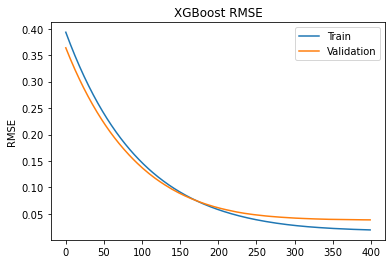

In [46]:
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Validation')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

The way of RMSE decreasing in the validation set suggests that it's quite resistant to overfitting (the validation RMSE did not pick up with increasing iterations). 

In [47]:
# ============== Save the model
filename_model = Savepath + 'ModelXGB_' + '.model'
print('[Saving] Save training model')
pickle.dump(xg_reg, open(filename_model, 'wb'))

[Saving] Save training model


In [ ]:
# You can load the model by the following way

# filename_model = Savepath + 'ModelXGB_' + '.model'
# xg_reg = pickle.load(open(filename_model, 'rb'))

#### Evaluate model performance

In [30]:
# ============== 1. MSE

# Predict the labels of the test set: preds
preds = xg_reg.predict(X_test)
mse_train = mean_squared_error(Y_test, preds)
mse_test = mean_squared_error(Y_test, preds)
print("train MSE: %f" % (mse_train))
print("test MSE: %f" % (mse_test))

Test RMSE: 0.038175
Test MSE: 0.001457


In [ ]:
# Export csv of MSE
print('[Saving] Save MSE evaluation')        
Result_pd = pd.DataFrame(data = {'mse_train':[mse_train], 'mse_test':[mse_test], 'time_train':[training_time]})   
filename_mse = 'MSE_' + m_name + '_' + Typemodel + '_' + str(resolution_grid) + '.csv'
Result_pd.to_csv(Savepath + filename_mse, sep='\t', encoding='utf-8')

Test MSE (0.001457) is rather low. 

#### Train/test/validate

Note that here we did not utilise the validation set. In fact, when tuning the parameters via grid search with cross validation, the algorithm is already splitting the `X_train` and `Y_train` into train and validation. We then use the tuned model to test on the `X_test`. 

We can of course combine the training and validation set as the 'train' set, and tune the parameter with this set. 

Originally, a separate validation set was created to help us tune the parameters manually after fitting on the training set. Depending on the size of the data, we can choose to merge the train and validation set when using grid search. However, a test set should always be prepared to evaluate the final model. 

#### Model output

In [34]:
# ============== 1. get feature importances
# it is the same API interface like for ‘scikit-learn’ models
xg_reg.feature_importances_

array([0.02457056, 0.00651738, 0.05812539, 0.03607241, 0.03076801,
       0.00968449, 0.02311396, 0.00657142, 0.00948244, 0.01887733,
       0.12187379, 0.02180333, 0.03338007, 0.14032926, 0.05349391,
       0.03077403, 0.01347822, 0.13066086, 0.05644577, 0.01766945,
       0.02818257, 0.05281393, 0.04471108, 0.011978  , 0.00544176,
       0.01318057], dtype=float32)

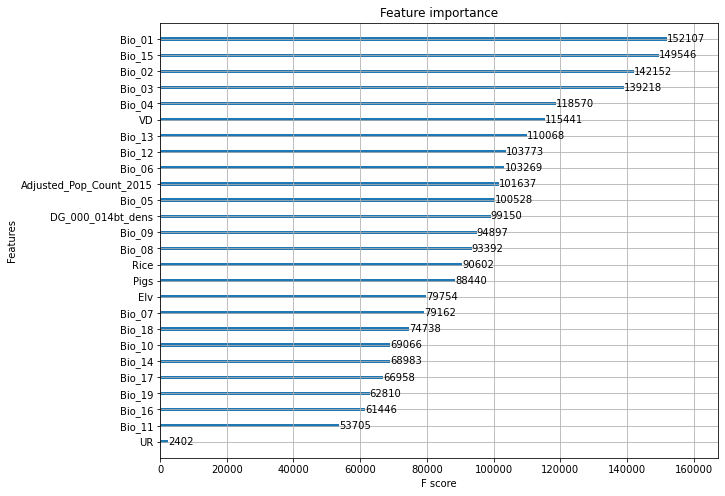

In [35]:
# Plot and save feature importances
figname = Savepath + 'XGB_feature_imp.png'
ax = xgb.plot_importance(xg_reg)
ax.figure.set_size_inches(10,8)
ax.figure.savefig(figname)

Text(0.5, 0, 'Permutation Importance')

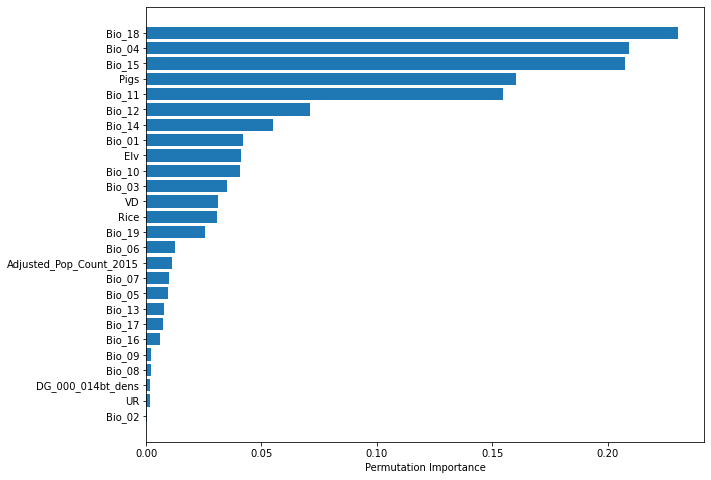

In [59]:
# ============== 2. get permutation-based feature importance
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(xg_reg, X_test, Y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize = (10,8))
plt.barh(X_train.columns.values[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

Similar to what you have seen the Gradient Boosting version of the anlaysis, the permutation importance and gain-based feature importance are not really consistent with each other. e.g. Bio_18, Bio_11. 

To recall:

- The default feature importance is the 'gain' type. It shows the average gain across all splits where feature was used. So we are calculating each feature's contribution for each tree in the model. A higher value means it is more important for generating a prediction. 

    - Idea: there are some wrongly classified points in the tree. We add the split on a feature X, there are two new branches. Each of these branches more accurately classifies the points than before, this is called a gain. 

- Permutation method randomly shuffle each feature, and compute the change in the model's performance. Features that impact the performance the most is considered the most important one. 

However, both methods can have problem with highly-correlated features. 

#### A note on the correlated features for boosting and random forrest

In the PCA analysis, we see substantial correlations among some variables. 

If feature A and feature B are perfectly correlated, when building a specific tree, both RF and Boosting will randomly choose either A or B. 

- However, in RF, this random choice will be done for each tree, as each tree is independently built (and there are many trees in each round), for each round. So approximately, in each round, 50% of the trees will choose A, and 50% will choose B. This dilutes the importance of the information in A & B, so you won't know if A or B is important for your prediction. 

- In gradient boosting, if the relationship between the feature X and the outcome has been learned, the algorithm will try not to refocus on it. Because theoretically, we are correcting the mistakes of the previous trees built by fitting the residuals (i.e. gradients). This is also how we prevent overfitting. So, all the importance will be either on feature A or B, but not both. 

The above explanation was provided by the inventor of XGboost, Tianqi Chen, see it here: https://cran.r-project.org/web/packages/xgboost/vignettes/discoverYourData.html#numeric-v.s.-categorical-variables

In summary, decision tree models are very robust to correlated features when it comes to prediction. However, when looking at the feature importance scores, 

- in RF: some important but correlated features may have low importance score

- in boosting: one of the pair of important but correlated features will be picked up, but not both



### Calculate prediction intervals

XGBoost's python package does not have the built-in function to calculate the prediction intervals. 

The ML community has been traditionally focusing more on prediction than uncertainty quantification. There is so far no concensus or published research on calculating the prediction intervals of XGBoost. Below I outlined 2 methods for reader's references. 

#### Method 1: use quantile regression

The below method is adapted from https://colab.research.google.com/drive/1KlRkrLi7JmVpprL94vN96lZU-HyFNkTq?usp=sharing#scrollTo=EbvnttJdyCmI

Description of the quantile regression can be found here: https://medium.com/@qucit/a-simple-technique-to-estimate-prediction-intervals-for-any-regression-model-2dd73f630bcb

I must admit that **I am not entirely sure about this method yet.**

In [17]:
# somehow, below version kept giving errors regarding nthread
# I have deleted the attributes with None value. See trial 2 below. 

class XGBQuantile(XGBRegressor):
    def __init__(self,quant_alpha=0.95,quant_delta = 1.0,quant_thres=1.0,quant_var =1.0,base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
                n_jobs=1, nthread=None, objective='reg:linear', random_state=0,reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,silent=True, subsample=1):
        self.quant_alpha = quant_alpha
        self.quant_delta = quant_delta
        self.quant_thres = quant_thres
        self.quant_var = quant_var

        super().__init__(base_score=base_score, booster=booster, colsample_bylevel=colsample_bylevel,
           colsample_bytree=colsample_bytree, gamma=gamma, learning_rate=learning_rate, max_delta_step=max_delta_step,
           max_depth=max_depth, min_child_weight=min_child_weight, missing=missing, n_estimators=n_estimators,
           n_jobs= n_jobs, nthread=nthread, objective=objective, random_state=random_state,
           reg_alpha=reg_alpha, reg_lambda=reg_lambda, scale_pos_weight=scale_pos_weight, seed=seed,
           silent=silent, subsample=subsample)

        self.test = None
    
    def fit(self, X, y):
        super().set_params(objective=partial(XGBQuantile.quantile_loss,alpha = self.quant_alpha,delta = self.quant_delta,threshold = self.quant_thres,var = self.quant_var) )
        super().fit(X,y)
        return self
    
    def predict(self,X):
        return super().predict(X)
    
    def score(self, X, y):
        y_pred = super().predict(X)
        score = XGBQuantile.quantile_score(y, y_pred, self.quant_alpha)
        score = 1./score
        return score
      
  # @staticmethod
    def quantile_loss(y_true,y_pred,alpha,delta,threshold,var):
        x = y_true - y_pred
        grad = (x<(alpha-1.0)*delta)*(1.0-alpha)-  ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )*x/delta-alpha*(x>alpha*delta)
        hess = ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )/delta 

        grad = (np.abs(x)<threshold )*grad - (np.abs(x)>=threshold )*(2*np.random.randint(2, size=len(y_true)) -1.0)*var
        hess = (np.abs(x)<threshold )*hess + (np.abs(x)>=threshold )
        return grad, hess
  
    # @staticmethod
    def original_quantile_loss(y_true,y_pred,alpha,delta):
        x = y_true - y_pred
        grad = (x<(alpha-1.0)*delta)*(1.0-alpha)-((x>=(alpha-1.0)*delta)& (x<alpha*delta) )*x/delta-alpha*(x>alpha*delta)
        hess = ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )/delta 
        return grad,hess


    # @staticmethod
    def quantile_score(y_true, y_pred, alpha):
        score = XGBQuantile.quantile_cost(x=y_true-y_pred,alpha=alpha)
        score = np.sum(score)
        return score

    # @staticmethod
    def quantile_cost(x, alpha):
        return (alpha-1.0)*x*(x<0)+alpha*x*(x>=0)

    # @staticmethod
    def get_split_gain(gradient,hessian,l=1):
        split_gain = list()
        for i in range(gradient.shape[0]):
            split_gain.append(np.sum(gradient[:i])**2/(np.sum(hessian[:i])+l)+np.sum(gradient[i:])**2/(np.sum(hessian[i:])+l)-np.sum(gradient)**2/(np.sum(hessian)+l) )

        return np.array(split_gain)

In [24]:
# trial 2
class XGBQuantile(XGBRegressor):
    def __init__(self,quant_alpha=0.95,quant_delta = 1.0,quant_thres=1.0,quant_var =1.0,base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,max_depth=3, min_child_weight=1, n_estimators=100,
                n_jobs=1, objective='reg:linear', random_state=0,reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1):
        self.quant_alpha = quant_alpha
        self.quant_delta = quant_delta
        self.quant_thres = quant_thres
        self.quant_var = quant_var

        super().__init__(base_score=base_score, booster=booster, colsample_bylevel=colsample_bylevel,
           colsample_bytree=colsample_bytree, gamma=gamma, learning_rate=learning_rate, max_delta_step=max_delta_step,
           max_depth=max_depth, min_child_weight=min_child_weight, n_estimators=n_estimators,
           n_jobs= n_jobs, objective=objective, random_state=random_state,
           reg_alpha=reg_alpha, reg_lambda=reg_lambda, scale_pos_weight=scale_pos_weight, 
       subsample=subsample)

        self.test = None
    
    def fit(self, X, y):
        super().set_params(objective=partial(XGBQuantile.quantile_loss,alpha = self.quant_alpha,delta = self.quant_delta,threshold = self.quant_thres,var = self.quant_var) )
        super().fit(X,y)
        return self
    
    def predict(self,X):
        return super().predict(X)
    
    def score(self, X, y):
        y_pred = super().predict(X)
        score = XGBQuantile.quantile_score(y, y_pred, self.quant_alpha)
        score = 1./score
        return score
      
  # @staticmethod
    def quantile_loss(y_true,y_pred,alpha,delta,threshold,var):
        x = y_true - y_pred
        grad = (x<(alpha-1.0)*delta)*(1.0-alpha)-  ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )*x/delta-alpha*(x>alpha*delta)
        hess = ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )/delta 

        grad = (np.abs(x)<threshold )*grad - (np.abs(x)>=threshold )*(2*np.random.randint(2, size=len(y_true)) -1.0)*var
        hess = (np.abs(x)<threshold )*hess + (np.abs(x)>=threshold )
        return grad, hess
  
    # @staticmethod
    def original_quantile_loss(y_true,y_pred,alpha,delta):
        x = y_true - y_pred
        grad = (x<(alpha-1.0)*delta)*(1.0-alpha)-((x>=(alpha-1.0)*delta)& (x<alpha*delta) )*x/delta-alpha*(x>alpha*delta)
        hess = ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )/delta 
        return grad,hess


    # @staticmethod
    def quantile_score(y_true, y_pred, alpha):
        score = XGBQuantile.quantile_cost(x=y_true-y_pred,alpha=alpha)
        score = np.sum(score)
        return score

    # @staticmethod
    def quantile_cost(x, alpha):
        return (alpha-1.0)*x*(x<0)+alpha*x*(x>=0)

    # @staticmethod
    def get_split_gain(gradient,hessian,l=1):
        split_gain = list()
        for i in range(gradient.shape[0]):
            split_gain.append(np.sum(gradient[:i])**2/(np.sum(hessian[:i])+l)+np.sum(gradient[i:])**2/(np.sum(hessian[i:])+l)-np.sum(gradient)**2/(np.sum(hessian)+l) )

        return np.array(split_gain)

In [18]:
def collect_prediction(X_train,y_train,X_test,y_test,estimator,alpha,model_name):
    estimator.fit(X_train,y_train)
    y_pred = estimator.predict(X_test)
    print( "{model_name} alpha = {alpha:.2f},score = {score:.1f}".format(model_name=model_name, alpha=alpha , score= XGBQuantile.quantile_score(y_test, y_pred, alpha)) )

    return y_pred

In [27]:
# this is 90% prediction interval
# params were set by author of this method, via grid search
# we did not tune the params for this problem

alpha = 0.95

regressor = XGBQuantile(objective='reg:linear', 
                        n_estimators = bestp['n_estimators'],
                          max_depth = bestp['max_depth'],
                          learning_rate = bestp['eta'])
# lower
regressor.set_params(quant_alpha=1.-alpha,quant_delta=1.0,quant_thres=5.0,quant_var=3.2)
preds_lower = collect_prediction(X_train,Y_train,X_test,Y_test,estimator=regressor,alpha=1.-alpha,model_name="Quantile XGB")

# upper
regressor.set_params(quant_alpha=alpha,quant_delta=1.0,quant_thres=6.0,quant_var = 4.2)
preds_upper = collect_prediction(X_train,Y_train,X_test,Y_test,estimator=regressor,alpha=alpha,model_name="Quantile XGB")


[12:03:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { quant_alpha, quant_delta, quant_thres, quant_var } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Quantile XGB alpha = 0.05,score = 101.0
[12:05:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { quant_alpha, quant_delta, quant_thres, quant_var } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:05:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { quant_alpha, quant_delta, quant_thres, quant_var } might not be used.

  Thi

In [28]:
preds_lower

array([0.03592657, 0.24233165, 0.16279416, ..., 0.16626443, 0.41387796,
       0.13996433], dtype=float32)

In [29]:
preds_upper

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5], dtype=float32)

In [31]:
# dataframe
dat = np.concatenate((Y_test.reshape(-1,1), 
                      preds.reshape(-1,1), 
                      preds_lower.reshape(-1,1), 
                      preds_upper.reshape(-1,1)), axis = 1)
dat = pd.DataFrame(dat, columns = ['y','yhat','lower','upper'])
dat.head()

,y,yhat,lower,upper
0,0.027360,0.036374,0.035927,0.5
1,0.240316,0.238928,0.242332,0.5
2,0.156686,0.164198,0.162794,0.5
3,0.189376,0.147855,0.146758,0.5
4,0.229561,0.142252,0.191517,0.5


In [32]:
# sort the dataframe for plotting
dat2 = dat.sort_values('y')
dat2.head()

,y,yhat,lower,upper
6256,4.301107e-08,0.026366,0.010499,0.5
49,4.321768e-08,0.028681,0.005399,0.5
6032,4.325576e-08,0.033536,0.020308,0.5
4186,4.342776e-08,0.037182,0.001789,0.5
6500,4.366941e-08,0.048647,0.019546,0.5


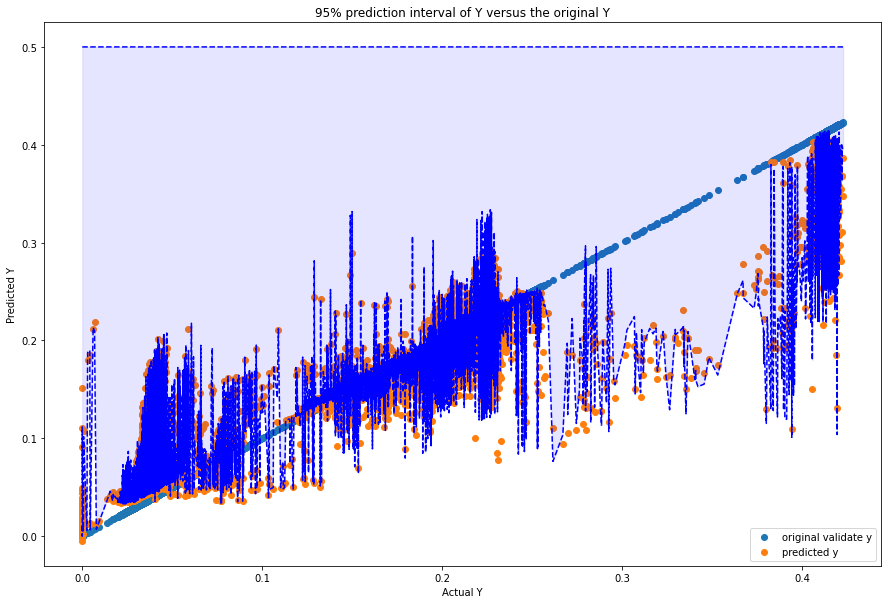

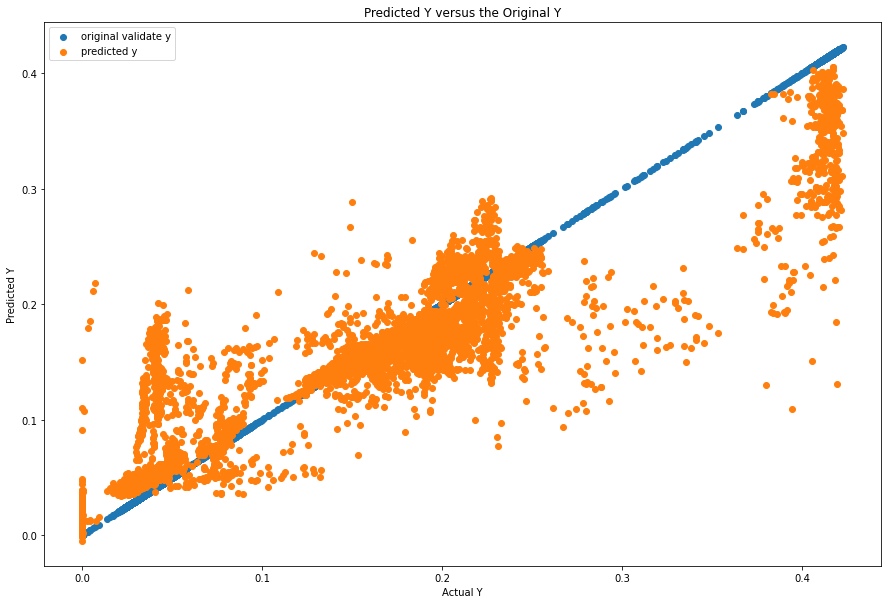

In [33]:
# plot1
fig, ax = plt.subplots(figsize = (15,10))
plt.scatter(dat2['y'], dat2['y'],label = 'original validate y')
plt.scatter(dat2['y'], dat2['yhat'],label = 'predicted y')
ax.plot(dat2['y'], dat2['upper'], '--', color = 'b')
ax.plot(dat2['y'], dat2['lower'], '--', color = 'b')
ax.fill_between(dat2['y'], dat2['lower'],dat2['upper'], color = 'blue',alpha = .1)
plt.xlabel('Actual Y')
plt.ylabel('Predicted Y')
plt.title('95% prediction interval of Y versus the original Y')
plt.legend()

# plot2
fig, ax = plt.subplots(figsize = (15,10))
plt.scatter(dat2['y'], dat2['y'],label = 'original validate y')
plt.scatter(dat2['y'], dat2['yhat'],label = 'predicted y')
# ax.plot(dat2['y'], dat2['upper'], '--', color = 'b')
# ax.plot(dat2['y'], dat2['lower'], '--', color = 'b')
# ax.fill_between(dat2['y'], dat2['lower'],dat2['upper'], color = 'blue',alpha = .1)
plt.xlabel('Actual Y')
plt.ylabel('Predicted Y')
plt.title('Predicted Y versus the Original Y')
plt.legend()

The prediction interval above is not very informative, especially on the upper bound. It could be that we need to further tune the params. It is also likely the disadvantage of the quantile regression method, as discussed here: https://medium.com/@qucit/a-simple-technique-to-estimate-prediction-intervals-for-any-regression-model-2dd73f630bcb. 

Alternatively, we may want to run the model on `X_test` for 100 times, and manually construct a prediction interval.

#### Method 2: draw predictions repeatedly

You may want to remove the set.seed from the model, and make predictions repeatedly. However, note that randomness is influencing the following parameters: 

- `colsample_bytree`
- `colsample_bylevel`
- `colsample_bynode`
- `sample`
- `shuffle`

We didn't tune the column and row selection percentage (the colsample and sample) in this model, so removing the set.seed is not going to make a difference for our prediction. However, it is possible (althought not required) to include those parameters to induce the randomness, and do parameter tuning. 

In one of the numerous attempts of parameter tuning, I included `colsample_bytree`. The resulting `bestp` gave very high learning rate (0.3). This is not ideal as we generally want boosted trees to learn slowly with many trees. The reader is welcome to experiment with this or other parameters. 

## Appendix

#### Syntax for GridSearchCV

In [ ]:
# Create the parameter grid: gbm_param_grid
gbm_param_grid = {
    'colsample_bytree': np.arange(3,8)/10,
    'n_estimators': range(20,100,10),
    'max_depth': range(2,101,2),
    'lambda':range(1,10,1)
}
# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor()
# Perform grid search: grid_mse
grid_mse = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid,
                       scoring='neg_mean_squared_error', cv=9, verbose=1)
grid_mse.fit(X_train, Y_train)
# Print the best parameters and lowest RMSE
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

# best: 'colsample_bytree': 0.7, 'max_depth': 5, 'n_estimators': 50
# but be aware that our max_depth is capped at 5


#### Syntax for individual parameter CV

In [65]:
# Use cv to tune individual params =============

# Create the parameter dictionary for each tree: params
params = {"objective":"reg:linear", "max_depth":3}
# Create list of number of boosting rounds
num_rounds = [5, 10, 15]
# Empty list to store final round rmse per XGBoost model
final_rmse_per_round = []
# Iterate over num_rounds and build one model per num_boost_round parameter
for curr_num_rounds in num_rounds:
    # Perform cross-validation: cv_results
    cv_results = xgb.cv(dtrain=train_dmatrix, params=params, nfold=3, num_boost_round=curr_num_rounds, metrics="rmse", as_pandas=True, seed=123)
    # Append final round RMSE
    final_rmse_per_round.append(cv_results["test-rmse-mean"].tail().values[-1])
# Print the resultant DataFrame
num_rounds_rmses = list(zip(num_rounds, final_rmse_per_round))
print(pd.DataFrame(num_rounds_rmses,columns=["num_boosting_rounds","rmse"]))

[17:45:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:45:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:45:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:45:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:45:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:45:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:17

#### Linear Learner: xgb.train

XGBoost’s own non-scikit-learn compatible function, not commonly used. Need to convert dataset into an optimized data structure called Dmatrix

In [ ]:
#convert dataset into an optimized data structure called Dmatrix
#that XGBoost supports and gives it acclaimed performance and efficiency gains

train_dmatrix = xgb.DMatrix(data=X_train,label=Y_train)
validate_dmatrix = xgb.DMatrix(data=X_validate,label=Y_validate)

In [13]:
# train the model - linear learner
# this will allow the regularization
xg_reg = xgb.XGBRegressor(objective='reg:linear', 
                          n_estimators=100, seed=123,
                         colsample_bytree = 0.3,max_depth = 5,
                         learning_rate = 0.1)
params = {"booster":"gblinear","objective":"reg:linear"}
xg_reg = xgb.train(params = params, dtrain=train_dmatrix, num_boost_round=100)
# Predict the labels of the test set: preds
preds = xg_reg.predict(validate_dmatrix)
# Compute and print the RMSE
rmse = np.sqrt(mean_squared_error(Y_validate,preds))
print("RMSE: %f" % (rmse))

[18:09:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 33026490887481389056.000000
